# **Leveraging Autoencoders and Attention Mechanisms for Improved GAN Music Generation**

### Authors:
- Gloria Isotton (gloria.isotton@studenti.unipd.it)
- Sara munafò (sara.munafo@studenti.unipd.it)    


### About libraries:
This code makes use of three libraries:
- **preprocess_midi.py** : is the library containing all the functions needed for the preprocessing of MIDI files; the functions belonging to this library are used to select melodies in the dataset, select specific tempo and ticks per beat, format the data into their final one-hot encoded form, and finally perform data augmentation.
- **gan_model.py** : is the library containing everything about the GAN model, from the architecture, to the training and testing function, the functions to generate a new song and convert it into a MIDI file, and the pch metric functions.
- **autoenc_model.py** : is the library containing the autoencoder model, used to implement the clustering and reconstruction loss; the training function of the autoencoder is also found inside the library, since the model was previously pretrained using this function.

In [ ]:
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
import mido
from mido import MidiFile, MidiTrack, Message
import pretty_midi
import numpy as np
import zipfile
import torch
import torch.nn as nn
#from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import random

from google.colab import drive
import shutil

from preprocess_midi import *  #needs upload of preprocess_midi.py
from autoenc_model import *    #needs upload of autoenc_model.py
from gan_model import *        #needs upload of gan_model.py

#### Standard MIDI File Structure    

A standard MIDI file consists of three main components:

1. Header Chunk: This provides metadata about the file.Chunk Type: 4 bytes, always "MThd".
   - Length: 4 bytes, always 6 (the length of the header data).|
   - Format Type: 2 bytes, indicating the file format (0, 1, or 2).
   - Number of Tracks: 2 bytes, indicating the number of track chunks in the file.
   - Time Division: 2 bytes, indicating the timing information (ticks per quarter note or frames per second).    
   

2. Track Chunk(s): Each track contains a sequence of MIDI events.
   - Chunk Type: 4 bytes, always "MTrk".
   - Length: 4 bytes, indicating the length of the track data.
   - Track Event Data: Variable length, consisting of MIDI events such as note on/off, control changes, and meta events.

# 0. PREPROCESSING

## 0.1 Get melodies from full dataset

https://colinraffel.com/projects/lmd/#get

In [ ]:
path_full = 'LAKH/lmd_full'
paths = []

directories = os.listdir(path_full)

for direc in directories:
    directory = f"{path_full}/{direc}"
    midi_files = [name for name in os.listdir(directory) if name.endswith('.mid')]
    for midi in midi_files:
        paths.append(f"{path_full}/{direc}/{midi}")

In [ ]:
len(paths)

178561

In [ ]:
melodies = []
corrupt = 0

for i,path in enumerate(paths):
    res = search_melodies(path)
    if res is not None:
        if res==1:
            melodies.append(path)
    else:
        corrupt += 1

/home/sara/anaconda3/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
print('Melodies found: ', len(melodies), '\nCorrupted files: ', corrupt)

Melodies found:  3144 
Corrupted files:  69210


In [ ]:
# Directory  to copy these files
target_directory = "/home/sara/Scrivania/Physics_of_Data/2nd_Year/NeuralNetworks_DeepLearning/Lab/Lakh_melodies"

for file_path in melodies:
    if os.path.isfile(file_path):
        shutil.copy(file_path, target_directory)
    else:
        print(f"File not found: {file_path}")

print("Files copied successfully.")

Files copied successfully.


## 0.2 Check for no-notes tracks and remove them

In [ ]:
target_directory = "/home/sara/Scrivania/Physics_of_Data/2nd_Year/NeuralNetworks_DeepLearning/Lab/Lakh_melodies"
paths = []
midi_files = os.listdir(target_directory)
for midi in midi_files:
    paths.append(f"{target_directory}/{midi}")


metadata = []

for midi_path in paths:
    notes, time = extract_note_events(midi_path, track_name='MELODY')
    notes = np.array(notes)

	#Check for corrupted files with no notes and remove them
    if (notes.shape[0]==0) or time==0:
        os.remove(midi_path)
        #print(f"No-note midi file, removed: {midi_path}")
    else:
        midi_file = mido.MidiFile(midi_path)
        tpb = midi_file.ticks_per_beat
        track0 = [track for track in midi_file.tracks if track.name=='']
        if len(track0)!=0:
            #get metamessage
            meta = [track0[0][i] for i in range(0,len(track0[0]))]
            metadata.append([tpb,meta,time])
        else:
            os.remove(midi_path)
            #print(f"No header file, removed: {midi_path}")

paths = []
midi_files = os.listdir(target_directory)
for midi in midi_files:
    paths.append(f"{target_directory}/{midi}")
print('Uncorrupted files remained: ', len(paths))

Uncorrupted files remained:  3140


## 0.4 Select 4/4 tempo, 384 ticks per beat

In [ ]:
indexes_, selected_paths, selected_meta = select_tempo(paths=paths, tpb=384, tempo_num=4, tempo_den=4, metadata=metadata)

In [ ]:
# define subset of the dataset with only these files:
target_directory = "/home/sara/Scrivania/Physics_of_Data/2nd_Year/NeuralNetworks_DeepLearning/Lab/Lakh_melodies_4_4"

# Copy each file to the target directory
for file_path in selected_paths:
    if os.path.isfile(file_path):  # Check if the file exists
        destination_path = os.path.join(target_directory, os.path.basename(file_path))
        if file_path != destination_path:  # Check if the source and destination are the same
            shutil.copy(file_path, destination_path)
        else:
            print(f"File is already in the target directory: {file_path}")
    else:
        print(f"File not found: {file_path}")

print("Files copied successfully.")

Files copied successfully.


In [ ]:
print('Cleaned melody dataset:\nTempo : 4/4\nTicks per beat : 384\nNumber of files : ',len(selected_paths))

Cleaned melody dataset:
Tempo : 4/4
Ticks per beat : 384
Number of files :  2698


 ## 0.5 Final formatting

The final phase of formatting consists of:
- Unpack notes into time series (one note for each tick)
- Remove silences by prolonging previous notes
- Possibly restrict notes into 2 octaves
- Represent notes as a 128 dimensional array with all zeroes except for the note
- Augment the dataset through transposition and rotation

At the end of this phase, an array $[\text{augmented songs}\times\text{bars}\times\text{notes per bar}\times \text{notes range}]=[43168\times 8 \times 16 \times 128]$ is obtained.

### 0.5.1 Data and prev_data with 16 notes per bar and all octaves

In [ ]:
# Importing files from dataset directory
# get data from new directory
paths_4_4 = []
target_directory = "/home/sara/Scrivania/Physics_of_Data/2nd_Year/NeuralNetworks_DeepLearning/Lab/Lakh_melodies_4_4"
midi_files = os.listdir(target_directory)

for midi in midi_files:
    paths_4_4.append(f"{target_directory}/{midi}")

In [ ]:
data = formatting(paths_4_4, tpb=384, tempo=4, npb=16, n_bars=8, restrict=False, shift_range=8, n_aug=15)

0 / 2698  midis processed successfully.

500 / 2698  midis processed successfully.

1000 / 2698  midis processed successfully.

1500 / 2698  midis processed successfully.

2000 / 2698  midis processed successfully.

2500 / 2698  midis processed successfully.



In [ ]:
np.save('lakh_fullaug_16.npy', dataset)

In [ ]:
data = np.load('lakh_fullaug_16.npy')

In [ ]:
#Split into train and test:

n_train = int(data.shape[0]*0.7)
train_data = data[:n_train,:,:,:]
test_data = data[n_train:,:,:,:]

In [ ]:
train_data.shape

(30217, 8, 16, 128)

In [ ]:
test_data.shape

(12951, 8, 16, 128)

In [ ]:
np.save('lakh_aug_16_TRAIN.npy', train_data)
np.save('lakh_aug_16_TEST.npy', test_data)


# IMPORTING DATASETS

In [ ]:
# Extract Train dataset from .zip
zip_file_path = '/content/lakh_aug_16_TRAIN.zip'
extract_dir = '/content/'

# Extract all the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
npy_file_path = '/content/lakh_aug_16_TRAIN.npy'

# Load the .npy file
train_data = np.load(npy_file_path)
print('Train dataset shape:', train_data.shape)

Train dataset shape: (30217, 8, 16, 128)


In [ ]:
# Define prev_train_data, which will be needed for the Conditioner CNN
prev_train_data = np.zeros((train_data.shape[0],8,16,128))
for i in range(train_data.shape[0]):
    for j in range(train_data.shape[1]-1):
        prev_train_data[i,j+1,:,:] = train_data[i,j,:,:]

In [ ]:
# Extract Test dataset from .zip
zip_file_path = '/content/lakh_aug_16_TEST.zip'
extract_dir = '/content/'

# Extract all the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
npy_file_path = '/content/lakh_aug_16_TEST.npy'

# Load the .npy file
test_data = np.load(npy_file_path)
print('Test dataset shape:', test_data.shape)

Test dataset shape: (12951, 8, 16, 128)


# 1. TRAINING

In [ ]:
# Create directory for saving model states
save_dir = '../models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
epochs = 50
lrD = 0.00001  # Learning rate for discriminator
lrG = 0.0005  # Learning rate for generator
p_invert = 0.3
batch_size = 72
nz = 100
lambda1 = 0.8
lambda2 = 10
attention = True
epsilon = 1e-10
pch = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
training(epochs, lrD, lrG, p_invert, batch_size, nz, lambda1, lambda2, train_data, prev_train_data, attention, device, epsilon, pch)

Starting training 

Epoch ----> [0/50]
Epoch ----> [10/50]
Epoch ----> [20/50]
Epoch ----> [30/50]
Epoch ----> [40/50]
Training complete, Kullback-Leibler between real and generated data: 0.1152


In [ ]:
#Plot pch of first and last epochs
real_pch_train = np.load('/content/real_pch_train.npy')
gen_pch_train = np.load('/content/gen_pch_train.npy')

first_real = real_pch_train[0]
first_gen = gen_pch_train[0]

last_real = real_pch_train[-1]
last_gen = gen_pch_train[-1]

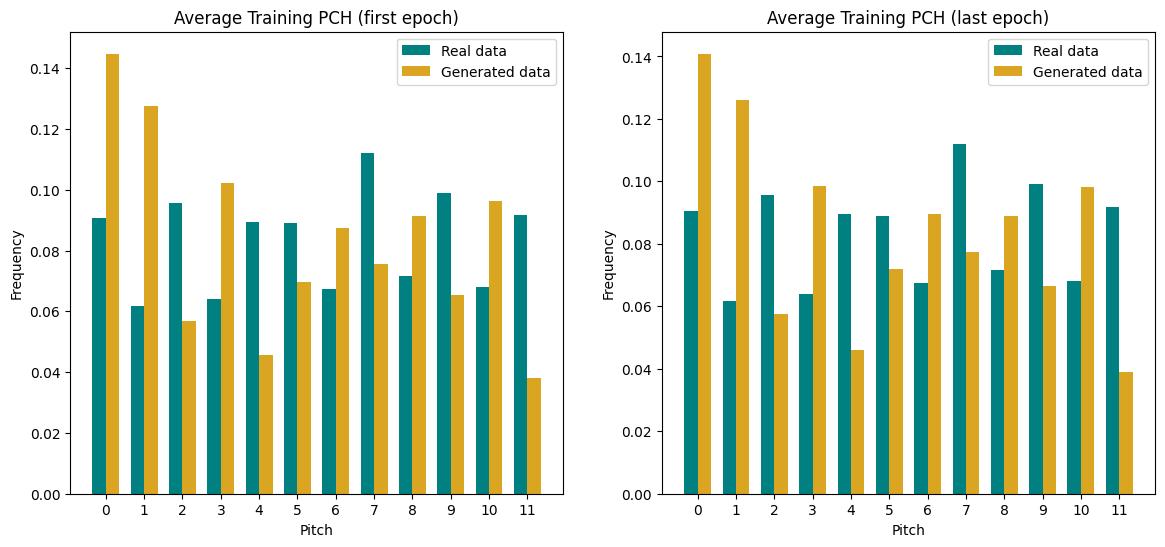

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define the x positions for the bars
x_positions = np.arange(12)
width = 0.35  # width of the bars

# First subplot
bars1_real = ax1.bar(x_positions - width/2, first_real, width, label='Real data', color='teal')
bars1_gen = ax1.bar(x_positions + width/2, first_gen, width, label='Generated data',color='goldenrod')

# Add labels, title, and legend to the first subplot
ax1.set_xlabel('Pitch')
ax1.set_ylabel('Frequency')
ax1.set_title('Average Training PCH (first epoch)')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(x_positions)
ax1.legend()

# Second subplot
bars2_real = ax2.bar(x_positions - width/2, last_real, width, label='Real data',color='teal')
bars2_gen = ax2.bar(x_positions + width/2, last_gen, width, label='Generated data', color='goldenrod')

# Add labels, title, and legend to the second subplot
ax2.set_xlabel('Pitch')
ax2.set_ylabel('Frequency')
ax2.set_title('Average Training PCH (last epoch)')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(x_positions)
ax2.legend()

plt.savefig('pch_train_plot.png')
# Show the plot
plt.show()

# 2. TESTING

In [ ]:
nz = 100
state_dict = torch.load('%s/netG_epoch_%d.pth' % ('../models', 49))
#state_dict = torch.load('%s/netG_epoch_%d.pth' % ('../content', 49))
attention = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epsilon = 1e-10
pch = True

In [ ]:
generated_test = testing(nz, test_data, state_dict, attention, device, epsilon, pch)

Starting testing 

Songs generated ----> [0/12951]
Songs generated ----> [1000/12951]
Songs generated ----> [2000/12951]
Songs generated ----> [3000/12951]
Songs generated ----> [4000/12951]
Songs generated ----> [5000/12951]
Songs generated ----> [6000/12951]
Songs generated ----> [7000/12951]
Songs generated ----> [8000/12951]
Songs generated ----> [9000/12951]
Songs generated ----> [10000/12951]
Songs generated ----> [11000/12951]
Songs generated ----> [12000/12951]
Testing completed, songs created: 12951
KL divergences for generated songs on test set: 0.4799 on first half,  6.8600 on second half


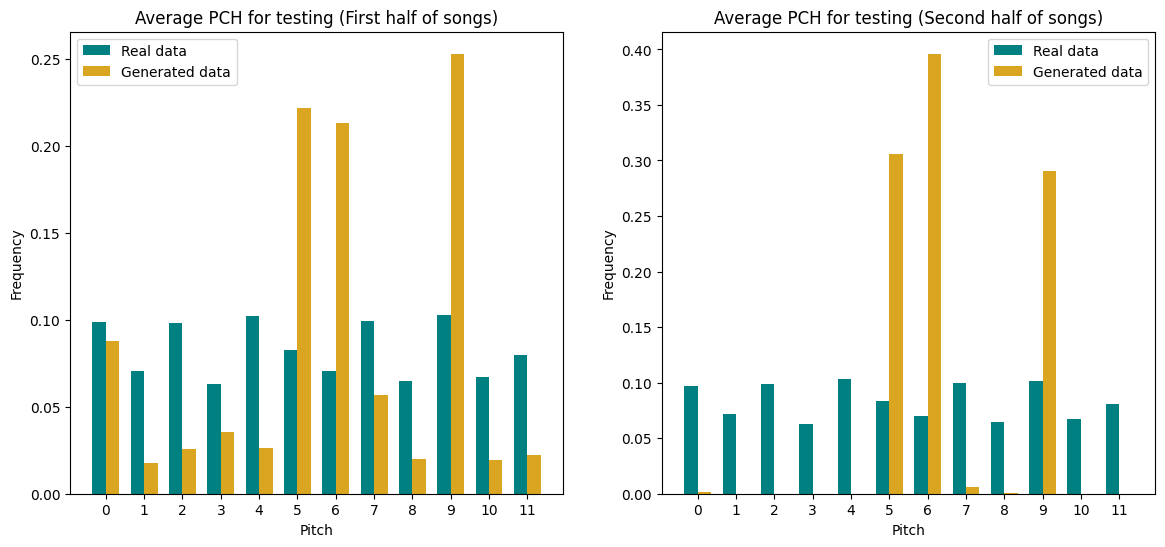

In [ ]:
#Plot test pch for first half and second half of songs

real_pch_test_1 = np.load('/content/real_pch_test_1.npy')
gen_pch_test_1 = np.load('/content/gen_pch_test_1.npy')
real_pch_test_2 = np.load('/content/real_pch_test_2.npy')
gen_pch_test_2 = np.load('/content/gen_pch_test_2.npy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define the x positions for the bars
x_positions = np.arange(12)
width = 0.35  # width of the bars

# First subplot
bars1_real = ax1.bar(x_positions - width/2, real_pch_test_1, width, label='Real data', color='teal')
bars1_gen = ax1.bar(x_positions + width/2, gen_pch_test_1, width, label='Generated data',color='goldenrod')

# Add labels, title, and legend to the first subplot
ax1.set_xlabel('Pitch')
ax1.set_ylabel('Frequency')
ax1.set_title('Average PCH for testing (First half of songs)')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(x_positions)
ax1.legend()

# Second subplot
bars2_real = ax2.bar(x_positions - width/2, real_pch_test_2, width, label='Real data',color='teal')
bars2_gen = ax2.bar(x_positions + width/2, gen_pch_test_2, width, label='Generated data', color='goldenrod')

# Add labels, title, and legend to the second subplot
ax2.set_xlabel('Pitch')
ax2.set_ylabel('Frequency')
ax2.set_title('Average PCH for testing (Second half of songs)')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(x_positions)
ax2.legend()

plt.savefig('pch_test_plot.png')
# Show the plot
plt.show()



In [ ]:
#Convert output to tensor and save
songs = torch.stack([tensors for tensors in generated_test[0]], dim=0).view(test_data.shape[0],8,16,128)
songs_array = np.array(songs.cpu().float())

npy_file_path = '/content/gen_data.npy'
np.save(npy_file_path,songs_array)

In [ ]:
# Save big generated dataset into drive
drive.mount('/content/drive')
destination_path = '/content/drive/My Drive/gen_data.npy'
shutil.copyfile(npy_file_path, destination_path)
print('File copied to Google Drive')


Mounted at /content/drive
File copied to Google Drive


# 3. GENERATE SAMPLES FROM TRAINED MODEL

In [ ]:
nz = 100
attention = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dict = torch.load('%s/netG_epoch_%d.pth' % ('../models', 49))
#state_dict = torch.load('%s/netG_epoch_%d.pth' % ('../content', 49))

new_sample = generate_sample(nz, test_data, state_dict, attention, device)

In [ ]:
new_sample.shape

torch.Size([8, 16, 128])

## 3.1 Convert tensors to midi

In [ ]:
output_path = 'sample_gen_song.midi'
midi1 = tensor_to_midi(new_sample.cpu(), output_path)

MIDI file saved to sample_test_6.midi


## 3.2 Generate nz new songs


In [ ]:
nz = 100
attention = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dict = torch.load('%s/netG_epoch_%d.pth' % ('../models', 49))

# Loop to generate and save 20 different songs
for i in range(1, 21):
    new_sample = generate_sample(nz, test_data, state_dict, attention, device)

    output_path = f'sample_gen_song_{i}.midi'

    midi1 = tensor_to_midi(new_sample.cpu(), output_path)

    print(f"Song {i} saved as {output_path}")


MIDI file saved to sample_gen_song_1.midi
Song 1 saved as sample_gen_song_1.midi
MIDI file saved to sample_gen_song_2.midi
Song 2 saved as sample_gen_song_2.midi
MIDI file saved to sample_gen_song_3.midi
Song 3 saved as sample_gen_song_3.midi
MIDI file saved to sample_gen_song_4.midi
Song 4 saved as sample_gen_song_4.midi
MIDI file saved to sample_gen_song_5.midi
Song 5 saved as sample_gen_song_5.midi
MIDI file saved to sample_gen_song_6.midi
Song 6 saved as sample_gen_song_6.midi
MIDI file saved to sample_gen_song_7.midi
Song 7 saved as sample_gen_song_7.midi
MIDI file saved to sample_gen_song_8.midi
Song 8 saved as sample_gen_song_8.midi
MIDI file saved to sample_gen_song_9.midi
Song 9 saved as sample_gen_song_9.midi
MIDI file saved to sample_gen_song_10.midi
Song 10 saved as sample_gen_song_10.midi
MIDI file saved to sample_gen_song_11.midi
Song 11 saved as sample_gen_song_11.midi
MIDI file saved to sample_gen_song_12.midi
Song 12 saved as sample_gen_song_12.midi
MIDI file saved to 

# 4. EVALUATION METRIC: Autoencoder embedding

## 4.1 Loading the model

In [ ]:
# For retraining autoencoder, if needed, uncomment following cell

# epochs = 30
# lr = 0.0005
# batch_size = 72
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# netAutoEncoder = AutoEncoder(72,16,2,1,16,128).to(device)
# state_path = 'autoencoder.pth'

# train_autoencoder(netAutoEncoder, epochs, lr, batch_size, train_data, device, state_path)

In [ ]:
#Extract Test output (if uploaded as .zip)
zip_file_path = '/content/gen_data.zip'
extract_dir = '/content/'

# Extract all the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# Load the .npy file
npy_file_path = '/content/gen_data.npy'
gen_data = np.load(npy_file_path)

In [ ]:
# Load the pretrained autoencoder state
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 72
netAutoEncoder = AutoEncoder(72,16,2,1,16,128).to(device)
state_path = '/content/autoencoder.pth'                       #pretrained with lr=0.0005 and epochs = 30
netAutoEncoder.load_state_dict(torch.load(state_path))
netAutoEncoder.eval()  # Set the model to evaluation mode

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 128), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 16, kernel_size=(2, 1), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(16, 16, kernel_size=(2, 1), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(16, 16, kernel_size=(2, 1), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.2)
  )
  (linear1): Linear(in_features=32, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(2, 1), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(16, 16, kernel_size=(2, 1), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(16, 16, kernel_size=(2, 1), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(16, 1, kernel_size=(1, 128), stride=(1, 2))
    (7): Sigmoid()
  )

 ## 4.2 PCA and clustering

In [ ]:
#Get latent representation of test dataset and generated
latent_test, decoded_test = get_latent_vectors(test_data, batch_size, netAutoEncoder, device)
latent_gen, decoded_gen = get_latent_vectors(gen_data, batch_size, netAutoEncoder, device)

In [ ]:
n_comp = 3
num_clust = 1
pca_test, clusters_test = pca_cluster(latent_test, n_comp, num_clust)
pca_gen, clusters_gen = pca_cluster(latent_gen, n_comp, num_clust)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


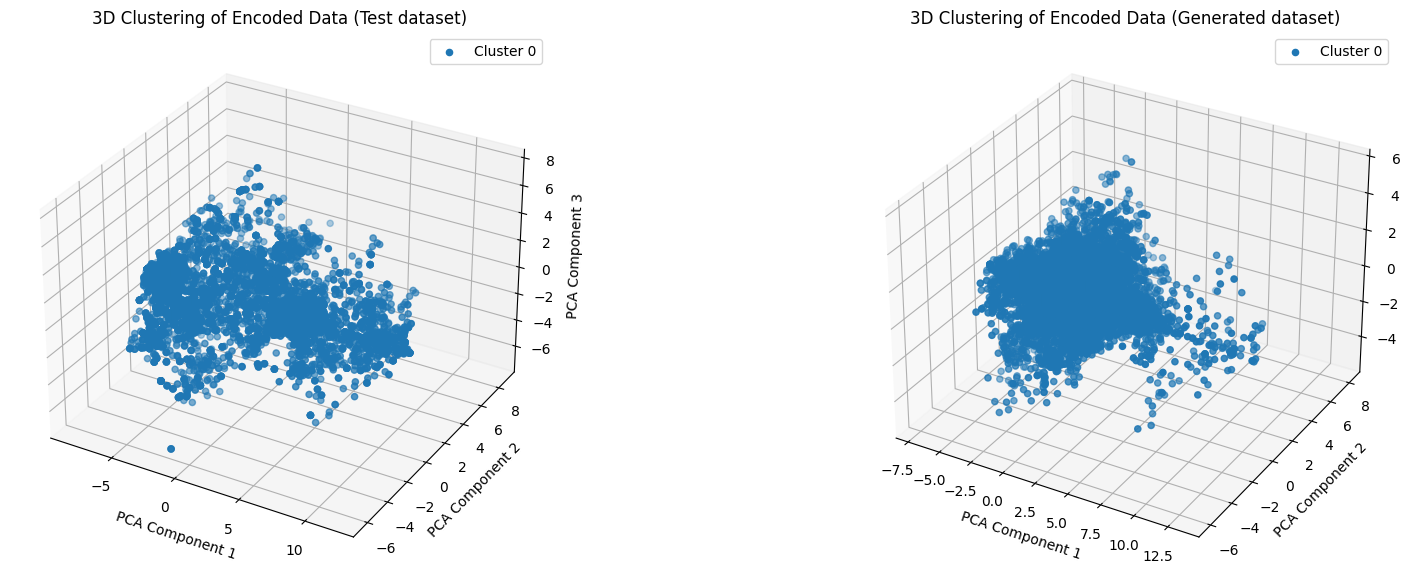

In [ ]:
# Create a figure with two subplots side by side
fig = plt.figure(figsize=(20, 7))  # Adjust the figsize to make room for both plots

# First subplot (left side)
ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 columns, 1st subplot

for cluster in range(num_clust):
    ax1.scatter(pca_test[clusters_test == cluster, 0], pca_test[clusters_test == cluster, 1], pca_test[clusters_test == cluster, 2], label=f'Cluster {cluster}')

ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('3D Clustering of Encoded Data (Test dataset)')
ax1.legend()

# Second subplot (right side)
ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 columns, 2nd subplot

for cluster in range(num_clust):
    ax2.scatter(pca_gen[clusters_gen == cluster, 0], pca_gen[clusters_gen == cluster, 1], pca_gen[clusters_gen == cluster, 2], label=f'Cluster {cluster}')

ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set_title('3D Clustering of Encoded Data (Generated dataset)')
ax2.legend()

plt.show()

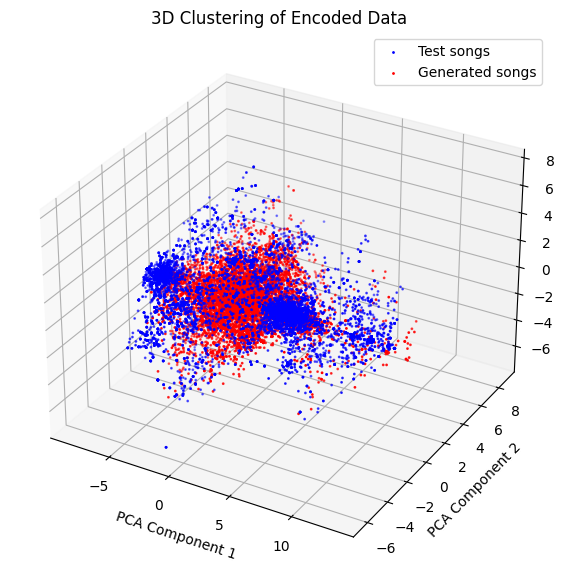

In [ ]:
# Create a figure with two subplots side by side
fig = plt.figure(figsize=(20, 7))  # Adjust the figsize to make room for both plots

# First subplot (left side)
ax1 = fig.add_subplot(111, projection='3d')  # 1 row, 1 column, 1st subplot

for cluster in range(num_clust):
    ax1.scatter(pca_test[clusters_test == cluster, 0],
                pca_test[clusters_test == cluster, 1],
                pca_test[clusters_test == cluster, 2],
                label=f'Test songs', color='blue', s=1)
    ax1.scatter(pca_gen[clusters_gen == cluster, 0],
                pca_gen[clusters_gen == cluster, 1],
                pca_gen[clusters_gen == cluster, 2],
                label=f'Generated songs', color = 'red', s=1)

ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('3D Clustering of Encoded Data')
ax1.legend()
plt.savefig('gen_test_clusterplot.png')
plt.show()

In [ ]:
# To see 3D interactive plot, uncomment below


#!pip install plotly
#import plotly.express as px
#import plotly.graph_objects as go

# Plotting in 3D using Plotly
#fig = px.scatter_3d(
#    x=pca_test[:, 0],
#    y=pca_test[:, 1],
#    z=pca_test[:, 2],
#    color=clusters_test.astype(str),  # Convert to string for discrete colors
#    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'},
#    title='3D Clustering of Encoded Data'
##)

#fig.update_traces(marker=dict(size=2))
#fig.show()

In [ ]:

# Plotting in 3D using Plotly
#fig = px.scatter_3d(
#    x=pca_gen[:, 0],
#    y=pca_gen[:, 1],
#    z=pca_gen[:, 2],
#    color=clusters_gen.astype(str),  # Convert to string for discrete colors
#    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'},
#    title='3D Clustering of Encoded  Generated Data'
#)

#fig.update_traces(marker=dict(size=2))
#fig.show()

## 4.3 Reconstruction loss

In [ ]:
reconstr_test = compute_reconstruction_loss(test_data,decoded_test, device)
reconstr_gen = compute_reconstruction_loss(gen_data,decoded_gen, device)

In [ ]:
print('Reconstruction error on the test set: ', reconstr_test)
print('Reconstruction error on the generated set: ', reconstr_gen)

Reconstruction error on the test set:  0.007442421745508909
Reconstruction error on the generated set:  0.007641003001481295


In [ ]:
reconstruction = np.array([reconstr_test,reconstr_gen])
np.save('reconstr_testgen.npy',reconstruction)